In [14]:
import pandas as pd
import sklearn as sk
from sklearn import model_selection
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

df = pd.read_csv('hf://datasets/maharshipandya/spotify-tracks-dataset/dataset.csv')
# Shuffle the dataset randomly to avoid any bias from alphabetical order
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Remove duplicates based on 'track_id' and 'track_name', keeping only the first occurrence
df_remove_duplicates = df_shuffled.drop_duplicates(subset=['track_id', 'track_name'], keep='first')

# Now, we no longer need these variables
drop_columns = ['Unnamed: 0', 'track_id', 'artists', 'track_name', 'album_name']
df = df_remove_duplicates.drop(columns=drop_columns).reset_index(drop=True)

# Step 1: Identify the top 50 genres by frequency
top_genres = df["track_genre"].value_counts().head(40).index

# Step 2: Filter the dataframe to include only rows with top genres
df = df[df["track_genre"].isin(top_genres)]

#create one-hot encodings for inordinal categorical variables
X = df.drop(['track_genre'], axis=1)
X = pd.get_dummies(X, columns=['explicit', 'key', 'mode', 'time_signature'], drop_first=True, dtype=int)

In [15]:
#train test split and scale
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, df['track_genre'], train_size=0.8)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [16]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

best_accuracy = -1
best_model = -1

# experiment with different numbers of neighbors
n_s = [5, 10, 15, 20, 25, 30, 35, 40]
for n in n_s:
      knn = KNeighborsClassifier(n)
      knn.fit(x_train, y_train)
      y_pred = knn.predict(x_test)
      cur_accuracy = accuracy_score(y_test, y_pred)

      if cur_accuracy > best_accuracy:
          best_accuracy = cur_accuracy
          best_model = n

print("best number of neighbors:", best_model, "yielded an accuracy score:", best_accuracy)


best number of neighbors: 5 yielded an accuracy score: 0.38620959332638166


In [17]:
#initial decision tree without hyperparameter tuning
genreDecisionTree = DecisionTreeClassifier(random_state=8743)
genreDecisionTree.fit(x_train, y_train)
y_pred = genreDecisionTree.predict(x_test)
y_test.to_numpy()
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.46728362877997914

In [18]:
#initial random forest without hyperparameter tuning
randomForest = RandomForestClassifier(random_state=8743, n_estimators=50)
randomForest.fit(x_train, y_train)
y_pred = randomForest.predict(x_test)
y_test.to_numpy()
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.6196558915537018

In [19]:
#hyperparameter tuning for decision tree
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)
grid_search.fit(x_train, y_train)


print(grid_search.best_params_)
print(grid_search.best_score_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
{'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10}
0.4768127749714844


In [20]:
#test on hyperparameter-tuned decision tree classifier
bestDecisionTree = grid_search.best_estimator_
y_pred = bestDecisionTree.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.48605318039624607

In [21]:
#hyperparameter tuning for random forest
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [5, 7, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)
grid_search.fit(x_train, y_train)

bestRF = grid_search.best_estimator_
bestRF

print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
0.6274401173211668


In [22]:
#test on hyperparameter-tuned random forest classifier
bestRF = grid_search.best_estimator_
y_pred = bestRF.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.6343847758081335

In [23]:
#PCA Analysis
from sklearn.decomposition import PCA

# With KNN and RF having decent accuracies, apply PCA and see how it affects accuracy:

# PCA (95% variance)
pca = PCA(n_components=3)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

# PCA on RF
rf_pca = RandomForestClassifier(random_state=42, n_estimators=150)
rf_pca.fit(x_train_pca, y_train)
y_pred_pca_rf = rf_pca.predict(x_test_pca)
rf_pca_accuracy = accuracy_score(y_test, y_pred_pca_rf)


print("RF with PCA:", rf_pca_accuracy)

RF with PCA: 0.22888425443169969


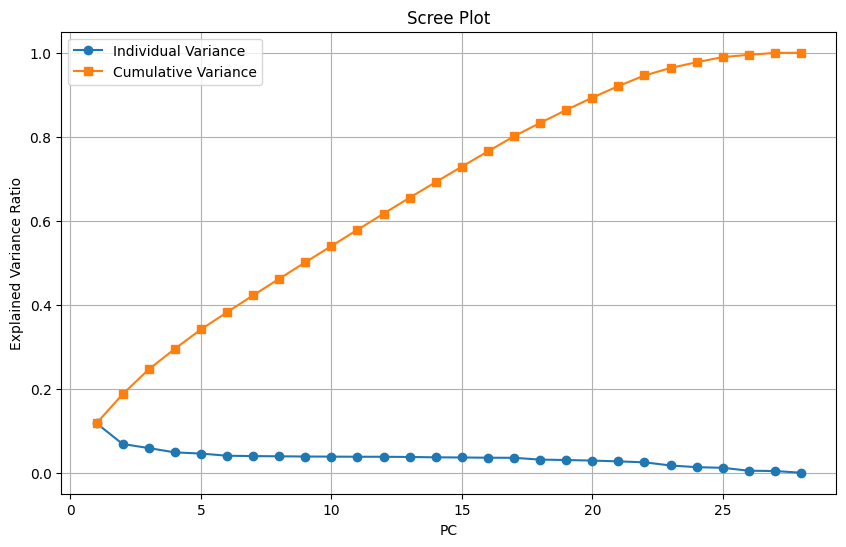

In [24]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# standardize
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

# fit PCA
pca = PCA()
x_train_pca = pca.fit_transform(x_train)

# plot
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = explained_variance_ratio.cumsum()
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', label='Individual Variance')
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='s', label='Cumulative Variance')
plt.title('Scree Plot')
plt.xlabel('PC')
plt.ylabel('Explained Variance Ratio')
plt.legend()
plt.grid()
plt.show()